Podaj nazwe pliku z danymi z IBIS-a (data.xls): most_freq.xls


<ipython-input-3-210b17f2cea7>:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data[row, column] = data_array[row, column].astype(np.float)


Czas rozpoczecia: 1260.00946 s
Czas zakonczenia: 1319.982676 s
Liczba probek: 5978
Czestotliwosc probkowania: 99.67782951642931 Hz
Podaj numer Rangebina do analizy: 5


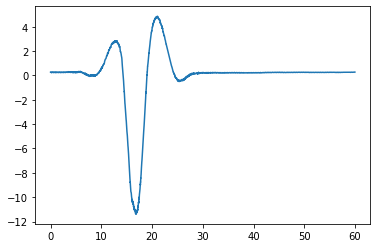

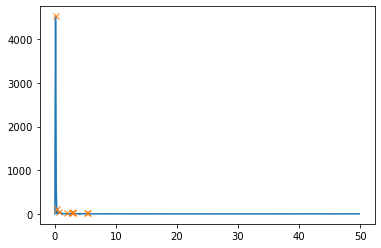

PEAK INDICES:  [  6  23  44 122 167 177 182 319 328]
PEAK FREQUENCIES:  [0.10007814 0.38363288 0.73390638 2.03492222 2.78550829 2.95230519
 3.03570364 5.32082122 5.47093843]


In [ ]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import scipy
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.signal import butter
from scipy.signal import filtfilt
import os
os.chdir(r'C:\a_sem_i\PP\temat_6_drgania\dane_wejsciowe')


def read_ibis_data(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        counts = sum(1 for row in reader)
    with open(filename, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        data_raw = [row for idx, row in enumerate(reader) if idx in range(3, counts)]
    data_array = np.asarray(data_raw)
    data = np.zeros((data_array.shape[0], data_array.shape[1] - 1))
    for row in range(data_array.shape[0]):
        for column in range(data_array.shape[1] - 1):
            data[row, column] = data_array[row, column].astype(np.float)
    N = counts - 3
    return data, N

def damped_oscillator(x, a, b, w, f):
    return a * np.exp(-b * x) * np.sin(w * x + f)

def damping_function(x, a, b):
    return a * np.exp(-b * x)

def lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


filename = input('Podaj nazwe pliku z danymi z IBIS-a (data.xls): ')
data, N = read_ibis_data(filename)

print(f'Czas rozpoczecia: {data[0, 0]} s')
print(f'Czas zakonczenia: {data[N-1, 0]} s')
print(f'Liczba probek: {N}')

Ts = (data[N-1, 0] - data[0, 0])/N              # okres probkowania
nyq = 0.5/Ts                                    # czestotliwosc Nyquista
print(f'Czestotliwosc probkowania: {1/Ts} Hz')

bin_idx = int(input('Podaj numer Rangebina do analizy: '))

x = np.linspace(0.0, N*Ts, N)
y = data[:, bin_idx] - np.mean(data[:, bin_idx])
yf = np.fft.fft(y)
spectrum = np.abs(yf[:N//2])
xf = np.linspace(0.0, nyq, N//2)
thresh = 0.002 * max(spectrum)
peaks, _ = find_peaks(spectrum, prominence=(thresh, None))

plt.plot(x, y)
plt.show()
plt.plot(xf, spectrum)
plt.plot(peaks/Ts/(N-2), spectrum[peaks], "x")
# plt.xlim(0,10)
plt.show()
pp = peak_prominences(spectrum, peaks)
print('PEAK INDICES: ', peaks)
peaks_scaled = peaks/Ts/(N-2)
print('PEAK FREQUENCIES: ', peaks_scaled)

if_damp = int(input('\nCzy wpasowac oscylator tlumiony? (1-tak, 0-nie): '))

if if_damp:
    params, params_cov = curve_fit(damped_oscillator, x, y)
    plt.scatter(x, y, marker='+', label='Data')
    plt.plot(x, damped_oscillator(x, params[0], params[1], params[2], params[3]), label='Fitted function')
    plt.plot(x, damping_function(x, params[0], params[1]))
    plt.show()

if_filt = int(input('\nCzy zastosowac filtr dolnoprzepustowy? (1-tak, 0-nie): '))

if if_filt:
    yb = lowpass_filter(y, cutoff=0.7, fs=1/Ts, order=2)
    plt.scatter(x, y, marker='.', label='Data')
    plt.scatter(x, yb, marker='+', label='Data filtered')
    plt.show()
